Baseline code to predict cell types with GNNs (edges based on gene expression similarity)

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data
from torch_geometric.utils import add_remaining_self_loops

import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv
import torch.nn as nn

from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from graphFeatureSelect.utils import get_adata
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import StratifiedKFold


custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.5, rc=custom_params)
%config InlineBackend.figure_format="retina"

In [2]:
# optimize architecture and multiple attention heads
class GATnet(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATv2Conv(num_features, hidden_channels)
        self.conv2 = GATv2Conv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


def train_gnn(model, optimizer, data, criterion):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(
        out[data.train_mask], data.y[data.train_mask]
    )  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def val_gnn(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    return val_acc


def test_gnn(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

In [3]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

In [21]:
class GATnet_mul_h(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.hidden_channels = hidden_channels
        self.conv1 = GATv2Conv(num_features, hidden_channels, heads=5, concat=False)
        self.conv2 = GATv2Conv(hidden_channels, num_classes, heads=5, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)

        # x = x.view((-1, self.hidden_channels, 5))
        # x = torch.mean(x, -1)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)

        return x

In [24]:
class GAT_mul_skip(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.hidden_channels = hidden_channels
        self.conv1 = GATv2Conv(num_features, hidden_channels, heads=5, concat=False)
        self.conv2 = GATv2Conv(hidden_channels, num_classes, heads=5, concat=False)
        self.lin1 = nn.Linear(num_features, num_classes)

    def forward(self, x, edge_index):
        residual = self.lin1(x)
        out = self.conv1(x, edge_index)

        # x = x.view((-1, self.hidden_channels, 5))
        # x = torch.mean(x, -1)
        out = out.relu()
        out = F.dropout(out, p=0.5, training=self.training)

        out = self.conv2(out, edge_index)
        out = out + residual

        return out

In [5]:
def training_loop(model, data, total_epoch):
    optimizer_self = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    loss_list = []
    for epoch in range(1, total_epoch + 1):
        loss = train_gnn(model, optimizer_self, data, criterion)
        val_acc = test_gnn(model, data)
        if epoch % 200 == 0:
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val acc: {val_acc:.4f}")
        loss_list.append(loss.detach().numpy())
    model.eval()
    val_acc = test_gnn(model, data)
    print(f"Model accuracy: {val_acc:.4f}")
    return val_acc, loss_list

In [6]:
adata = get_adata()

/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
# selecting 1 layer of anndata
# use supertype not subclass
display(adata.obs[["brain_section_label", "z_section"]].sort_values("z_section").value_counts().to_frame().head(4))
one_sec = adata[adata.obs["z_section"] == 5.0, :]
df = one_sec.obs.copy()
num_nodes = df.shape[0]
cell_type = "supertype"

,,count
brain_section_label,z_section,
C57BL6J-638850.30,5.0,9242
C57BL6J-638850.29,4.8,8713
C57BL6J-638850.28,4.6,7780
C57BL6J-638850.31,5.4,6939


In [8]:
# creating train/test masks
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Keep cells who are participants in the multilayer graph (more than 1 connection)
train_idx, test_idx = next(skf.split(np.arange(df.shape[0]), df[cell_type].values))

train_mask = np.zeros(df.shape[0], dtype=bool)
train_mask[train_idx] = True
train_mask = torch.tensor(train_mask, dtype=torch.bool)

test_mask = np.zeros(df.shape[0], dtype=bool)
test_mask[test_idx] = True
test_mask = torch.tensor(test_mask, dtype=torch.bool)

labels = torch.tensor(df[cell_type].cat.codes.values, dtype=torch.long)

/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [9]:
# constructing edges with nearest neighbors
k = 10
X = df[["x_reconstructed", "y_reconstructed"]]

A = kneighbors_graph(X, n_neighbors=k, mode="distance", include_self=False)

edgelist_knn = torch.tensor(list(zip(A.tocoo().row, A.tocoo().col)))
edgelist_knn = add_remaining_self_loops(edgelist_knn.T)[0]

edgelist_self = torch.tensor([[i, i] for i in range(num_nodes)])
edgelist_self = edgelist_self.T

In [10]:
one_sec_x = torch.tensor(one_sec.X.todense(), dtype=torch.float)
data_knn = Data(x=one_sec_x, edge_index=edgelist_knn, y=labels, train_mask=train_mask, test_mask=test_mask)
data_self = Data(x=one_sec_x, edge_index=edgelist_self, y=labels, train_mask=train_mask, test_mask=test_mask)

In [25]:
model_knn = GCN(hidden_channels=32, num_features=data_knn.x.shape[1], num_classes=torch.unique(data_knn.y).size()[0])
model_self = GCN(hidden_channels=32, num_features=data_self.x.shape[1], num_classes=torch.unique(data_self.y).size()[0])
model_knn_gat = GATnet(
    hidden_channels=32, num_features=data_knn.x.shape[1], num_classes=torch.unique(data_knn.y).size()[0]
)

model_knn_gat_mul_h = GATnet_mul_h(
    hidden_channels=32, num_features=data_knn.x.shape[1], num_classes=torch.unique(data_knn.y).size()[0]
)
model_knn_mul_skip = GAT_mul_skip(
    hidden_channels=32, num_features=data_knn.x.shape[1], num_classes=torch.unique(data_knn.y).size()[0]
)

Epoch: 200, Loss: 0.0343, Val acc: 0.8702
Epoch: 400, Loss: 0.0177, Val acc: 0.8729
Epoch: 600, Loss: 0.0178, Val acc: 0.8772
Epoch: 800, Loss: 0.0166, Val acc: 0.8799
Epoch: 1000, Loss: 0.0159, Val acc: 0.8767
Model accuracy: 0.8767


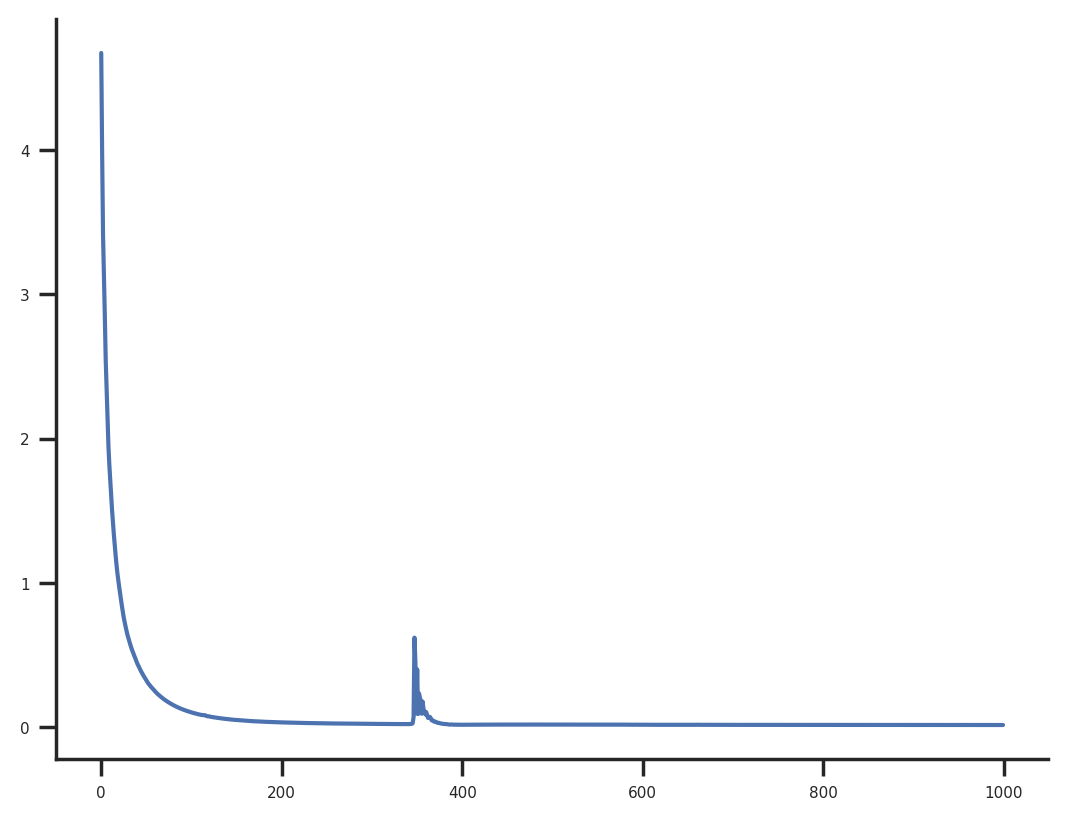

In [12]:
val_acc, loss_list0 = training_loop(model_self, data_self, 1000)
plt.plot(loss_list0)

Epoch: 200, Loss: 1.7351, Val acc: 0.4727
Epoch: 400, Loss: 1.6611, Val acc: 0.4597
Epoch: 600, Loss: 1.6322, Val acc: 0.4554
Epoch: 800, Loss: 1.6112, Val acc: 0.4565
Epoch: 1000, Loss: 1.5985, Val acc: 0.4565
Model accuracy: 0.4565


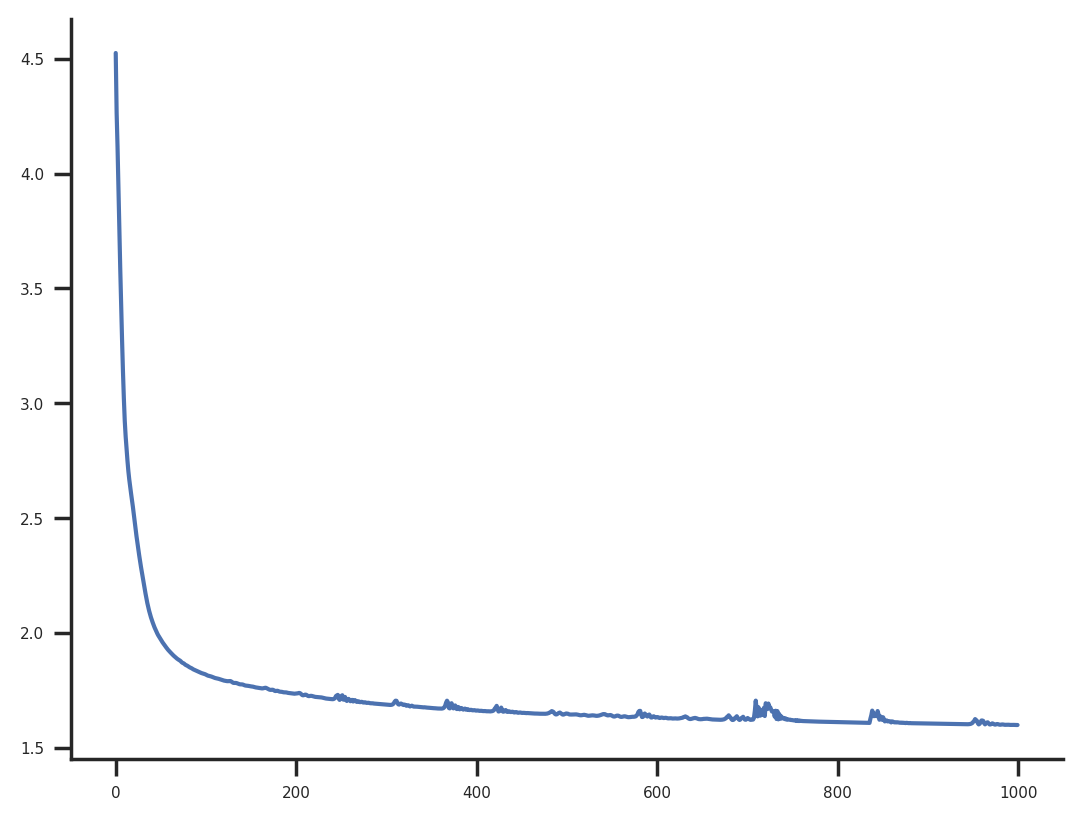

In [13]:
val_acc, loss_list1 = training_loop(model_knn, data_knn, 1000)
plt.plot(loss_list1)

Epoch: 200, Loss: 0.7544, Val acc: 0.7269
Epoch: 400, Loss: 0.5550, Val acc: 0.7507
Epoch: 600, Loss: 0.4954, Val acc: 0.7701
Epoch: 800, Loss: 0.4477, Val acc: 0.7653
Epoch: 1000, Loss: 0.4079, Val acc: 0.7707
Model accuracy: 0.7707


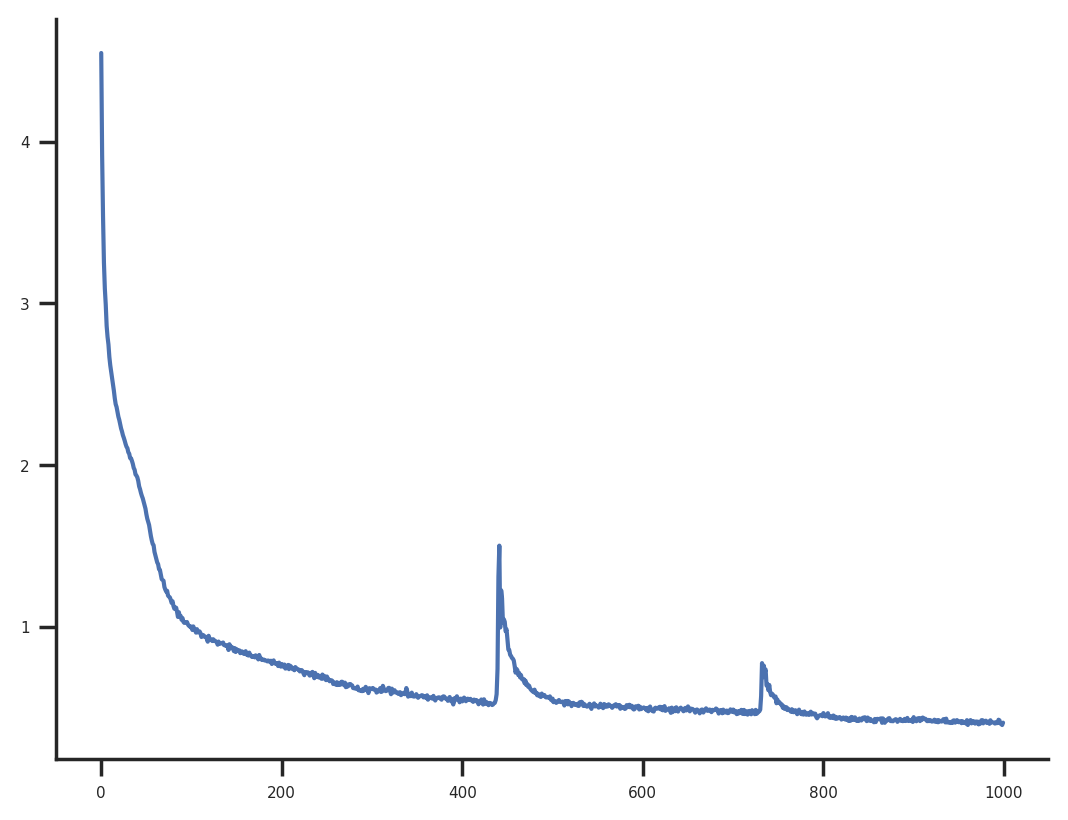

In [13]:
val_acc, loss_list2 = training_loop(model_knn_gat, data_knn, 1000)
plt.plot(loss_list2)

Epoch: 200, Loss: 0.6349, Val acc: 0.7507
Epoch: 400, Loss: 0.5212, Val acc: 0.7961
Epoch: 600, Loss: 0.3444, Val acc: 0.8183
Epoch: 800, Loss: 0.3004, Val acc: 0.8123
Epoch: 1000, Loss: 0.2986, Val acc: 0.8123
Model accuracy: 0.8123


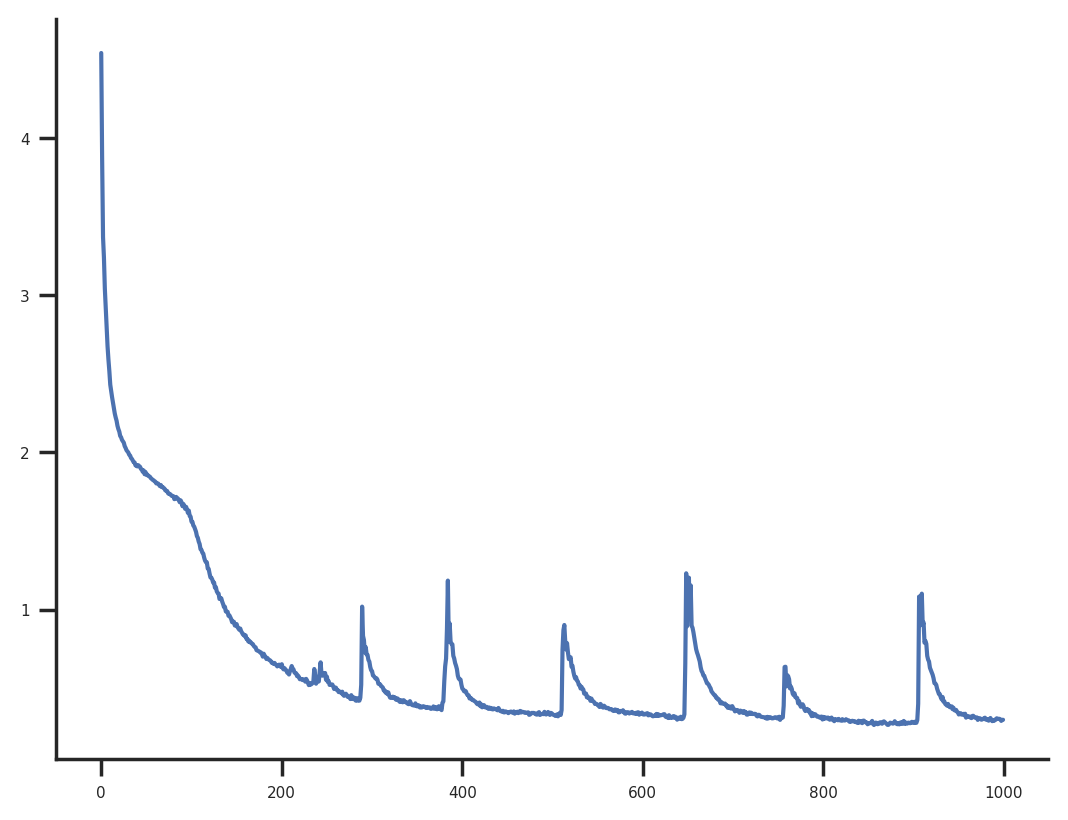

In [23]:
val_acc, loss_list3 = training_loop(model_knn_gat_mul_h, data_knn, 1000)
plt.plot(loss_list3)

Epoch: 200, Loss: 0.0577, Val acc: 0.8810
Epoch: 400, Loss: 0.0403, Val acc: 0.8837
Epoch: 600, Loss: 0.0355, Val acc: 0.8848
Epoch: 800, Loss: 0.0334, Val acc: 0.8864
Epoch: 1000, Loss: 0.0324, Val acc: 0.8891
Model accuracy: 0.8891


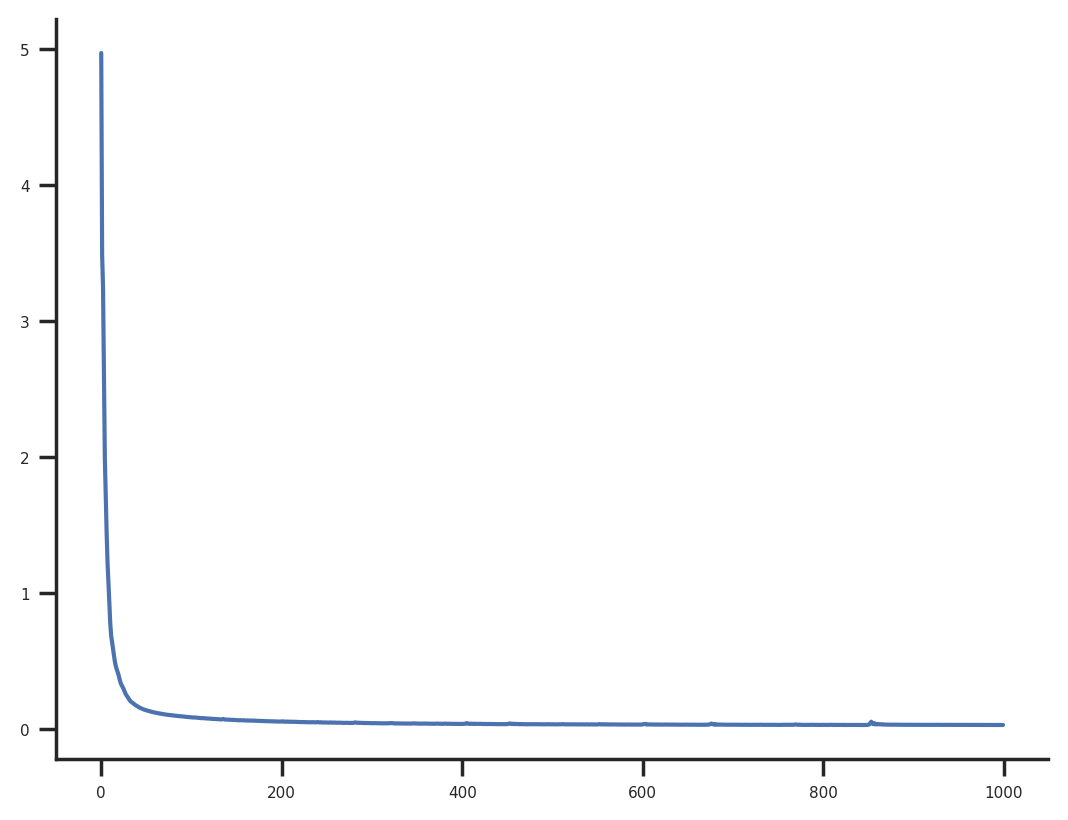

In [26]:
val_acc, loss_list3 = training_loop(model_knn_mul_skip, data_knn, 1000)
plt.plot(loss_list3)

In [42]:
k = 50
A = kneighbors_graph(X, n_neighbors=k, mode="distance", include_self=False)

edgelist_knn = torch.tensor(list(zip(A.tocoo().row, A.tocoo().col)))
edgelist_knn = add_remaining_self_loops(edgelist_knn.T)[0]

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

# cos similarity matrix based on gene expression
gene_expr_similarity = cosine_similarity(one_sec.X)

In [44]:
from scipy import sparse

gene_expr_similarity_csr = sparse.csr_matrix(gene_expr_similarity)

In [45]:
A[gene_expr_similarity_csr < 0.85] = 0
print(A.count_nonzero())
A.eliminate_zeros()

/tmp/ipykernel_4098710/3375996423.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  A[gene_expr_similarity_csr < 0.85] = 0
/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


43173


In [47]:
edgelist_cos = torch.tensor(list(zip(A.tocoo().row, A.tocoo().col)))
edgelist_cos = add_remaining_self_loops(edgelist_cos.T)[0]
data_cos = Data(x=one_sec_x, edge_index=edgelist_cos, y=labels, train_mask=train_mask, test_mask=test_mask)
model_cos = GATnet_mul_h(
    hidden_channels=16, num_features=data_cos.x.shape[1], num_classes=torch.unique(data_cos.y).size()[0]
)

In [50]:
edges_connecting_same_celltype = 0
for i in range(edgelist_cos.shape[1]):
    a, b = edgelist_cos[:, i]
    if labels[a] == labels[b]:
        edges_connecting_same_celltype += 1

In [51]:
edges_connecting_same_celltype / edgelist_cos.shape[1]

0.8134158254640182

Epoch: 200, Loss: 0.3192, Val acc: 0.8502
Epoch: 400, Loss: 0.2349, Val acc: 0.8502
Epoch: 600, Loss: 0.1875, Val acc: 0.8507
Epoch: 800, Loss: 0.1940, Val acc: 0.8502
Epoch: 1000, Loss: 0.1792, Val acc: 0.8469
Model accuracy: 0.8469


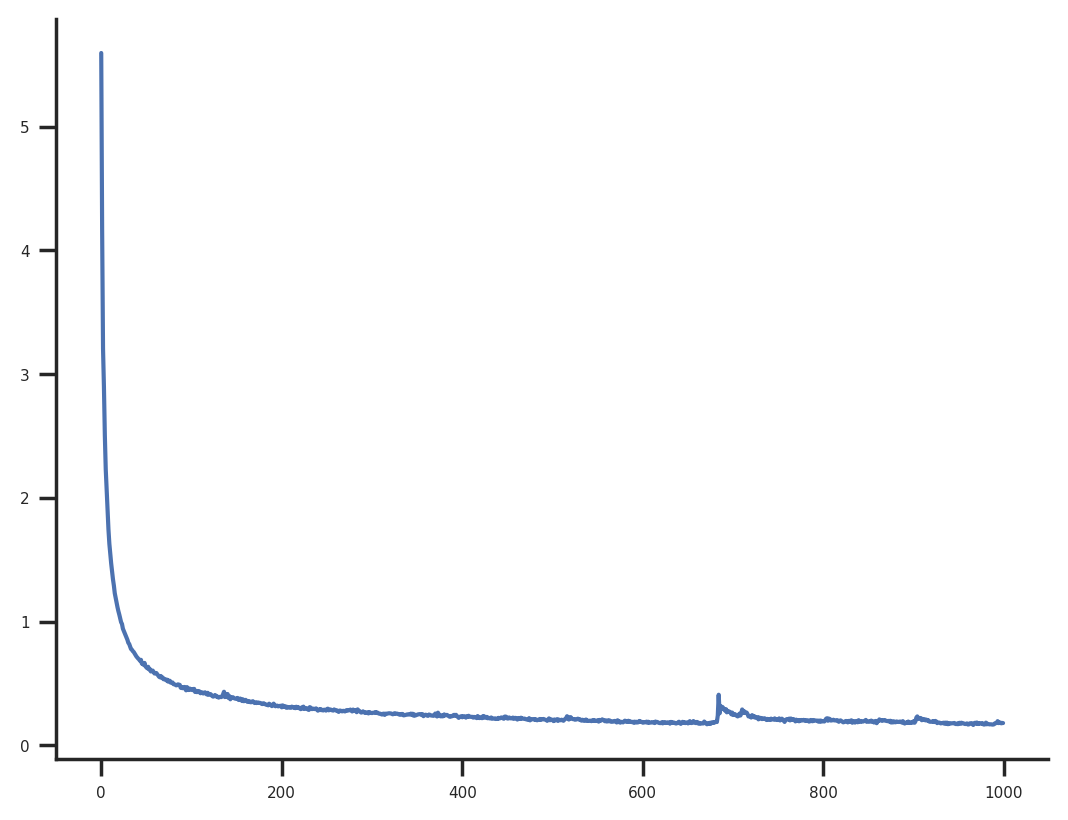

In [52]:
val_acc, loss_list2 = training_loop(model_cos, data_cos, 1000)
plt.plot(loss_list2)